In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings("ignore")
import datetime as dt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer,StandardScaler,MinMaxScaler,RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

# **Exploratory Data Analysis**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#load the treated dataset
df = pd.read_csv("/content/drive/MyDrive/new_file.csv")
#Take only the UK based transactions
df_uk = df[df['Country'] == 'United Kingdom']
#Cancellations are not needed for the analysis so they can be removed
df_uk = df_uk[~(df_uk['InvoiceNo'].str.contains('C'))]
# Remove the 13256 customer
df_uk = df_uk[df_uk['CustomerID'] != 13256]

In [5]:
#shape of the dataset
print("The shape of the dataset is: ", df_uk.shape)

The shape of the dataset is:  (349226, 16)


In [6]:
df_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,Date,Year,Year_Month,Quarter,Month,Day,Hour,UnitPrice,CustomerID,Country,Total_Price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2010-12-01,2010,2010-12,4,12,2,8,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,2010-12-01,2010,2010-12,4,12,2,8,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2010-12-01,2010,2010-12,4,12,2,8,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,2010-12-01,2010,2010-12,4,12,2,8,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,2010-12-01,2010,2010-12,4,12,2,8,3.39,17850,United Kingdom,20.34


In [7]:
df_uk.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,Date,Year,Year_Month,Quarter,Month,Day,Hour,UnitPrice,CustomerID,Country,Total_Price
401584,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,2011-12-09 12:31:00,2011-12-09,2011,2011-12,4,12,4,12,1.95,15804,United Kingdom,23.4
401585,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-12-09 12:49:00,2011-12-09,2011,2011-12,4,12,4,12,2.95,13113,United Kingdom,23.6
401586,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,2011-12-09 12:49:00,2011-12-09,2011,2011-12,4,12,4,12,1.25,13113,United Kingdom,30.0
401587,581586,21217,RED RETROSPOT ROUND CAKE TINS,24,2011-12-09 12:49:00,2011-12-09,2011,2011-12,4,12,4,12,8.95,13113,United Kingdom,214.8
401588,581586,20685,DOORMAT RED RETROSPOT,10,2011-12-09 12:49:00,2011-12-09,2011,2011-12,4,12,4,12,7.08,13113,United Kingdom,70.8


### Summary of the dataset

In [8]:
df_uk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349226 entries, 0 to 401588
Data columns (total 16 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    349226 non-null  object 
 1   StockCode    349226 non-null  object 
 2   Description  349226 non-null  object 
 3   Quantity     349226 non-null  int64  
 4   InvoiceDate  349226 non-null  object 
 5   Date         349226 non-null  object 
 6   Year         349226 non-null  int64  
 7   Year_Month   349226 non-null  object 
 8   Quarter      349226 non-null  int64  
 9   Month        349226 non-null  int64  
 10  Day          349226 non-null  int64  
 11  Hour         349226 non-null  int64  
 12  UnitPrice    349226 non-null  float64
 13  CustomerID   349226 non-null  int64  
 14  Country      349226 non-null  object 
 15  Total_Price  349226 non-null  float64
dtypes: float64(2), int64(7), object(7)
memory usage: 45.3+ MB


In [9]:
Features = df_uk.columns

# Creating a DataFrame with useful information about dataset
data_info = pd.DataFrame()
data_info['Features'] = Features
data_info['unique_values'] = [df_uk[col].nunique() for col in Features]
data_info['total_null'] = [df_uk[col].isnull().sum() for col in Features]
data_info['null_percent'] = [df_uk[col].isnull().sum() * 100 / len(df_uk) for col in Features]

data_info.style.background_gradient()

,Features,unique_values,total_null,null_percent
0,InvoiceNo,16648,0,0.000000
1,StockCode,3645,0,0.000000
2,Description,3844,0,0.000000
3,Quantity,293,0,0.000000
4,InvoiceDate,15614,0,0.000000
5,Date,305,0,0.000000
6,Year,2,0,0.000000
7,Year_Month,13,0,0.000000
8,Quarter,4,0,0.000000
9,Month,12,0,0.000000


In [10]:
df_uk.describe()

,Quantity,Year,Quarter,Month,Day,Hour,UnitPrice,CustomerID,Total_Price
count,349226.000000,349226.000000,349226.000000,349226.000000,349226.000000,349226.000000,349226.000000,349226.000000,349226.000000
mean,12.145422,2010.932826,2.862636,7.635153,2.633764,12.803697,2.972132,15548.340189,20.860488
std,190.622561,0.250324,1.120697,3.416509,1.951523,2.246194,17.990332,1594.400641,328.406504
min,1.000000,2010.000000,1.000000,1.000000,0.000000,6.000000,0.000000,12346.000000,0.000000
25%,2.000000,2011.000000,2.000000,5.000000,1.000000,11.000000,1.250000,14191.000000,4.200000
50%,4.000000,2011.000000,3.000000,9.000000,2.000000,13.000000,1.950000,15518.000000,10.200000
75%,12.000000,2011.000000,4.000000,11.000000,4.000000,14.000000,3.750000,16931.000000,17.850000
max,80995.000000,2011.000000,4.000000,12.000000,6.000000,20.000000,8142.750000,18287.000000,168469.600000


## **Check for last observed date in the dataset**

In [11]:
df_uk['InvoiceDate'] = pd.to_datetime(df_uk['InvoiceDate'])
df_uk['InvoiceDate'].describe()

count                  349226
unique                  15614
top       2011-11-14 15:27:00
freq                      542
first     2010-12-01 08:26:00
last      2011-12-09 12:49:00
Name: InvoiceDate, dtype: object

#### **Observations**
- The last date in the dataset is 2011-12-09 and RFM analysis is done on the next day to it, to calculate Recency.

## **RFM analysis**
- Recency: when was the last time the customer made a purchase? Customers who purchased from you recently are more likely to buy from you again than customers from the distant past. Deduct most recent purchase date from today to calculate the recency value. 1 day ago? 14 days ago? 500 days ago? This is the important ranking factor–that’s why it’s first in the list.

- Frequency: How many times has the customer purchased from our store? For example, if someone placed 10 orders over a period of time, their frequency is 10. A customer who is in every day is much more likely to buy again that someone who only comes in once a year.

- Monetary: how much did the customer spend? Simply total up the money from all transactions to get the M value. A customer who makes a large purchase is more likely to buy again than a customer who spends a lot less.


In [12]:
Present = dt.datetime(2011,12,10)
Present

datetime.datetime(2011, 12, 10, 0, 0)

In [13]:
RFM_table= df_uk.groupby('CustomerID').agg({'InvoiceDate': lambda date: (Present - date.max()).days,
                                      'InvoiceNo': lambda num: num.nunique(),
                                      'Total_Price': lambda price: price.sum()}).reset_index()
RFM_table.columns = ['CustomerID','Recency','Frequency','Monetary']
RFM_table.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,325,1,77183.60
1,12747,2,11,4196.01
2,12748,0,210,33053.19
3,12749,3,5,4090.88
4,12820,3,4,942.34


In [14]:
df_uk[df_uk['CustomerID'] == 12346]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,Date,Year,Year_Month,Quarter,Month,Day,Hour,UnitPrice,CustomerID,Country,Total_Price
37511,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,2011-01-18,2011,2011-01,1,1,1,10,1.04,12346,United Kingdom,77183.6


#### **Observations**
- The customer 12346 has last purchased during the month of January and was his only purchase. But, the customer has purchased for huge sum.

- This behaviour is a classic example which was mentioned above questioning - a A segment of customers who are big spenders but what if they purchased only once? 

- This also disproves the theory that a customer who makes a large purchase is more likely to buy again than a customer who spends a lot less. Consider, customer 12747, whose monetary value is very less but his recency and Frequency is more which makes the customer more loyal.

- This typically calls for RFM based segmentation by not restricting to value a customer by only Monetarily.  

## **Compute Customer LifeTime Value**
- The Life Time Value or LTV is an estimate of the average revenue that a customer will generate throughout their lifespan as a customer.
- This 'worth' of a customer can help determine many economic decisions for a company including marketing budget, resources, profitability and forecasting.

CLTV = ((Average Order Value x Avg Purchase Frequency rate)/Churn Rate) x Profit margin

CLTV = Customer value x Avg customer Lifespan


### Average Order value - Total money spent/Total number of orders

In [15]:
cltv_tab = df_uk.groupby('CustomerID').agg({'InvoiceNo': lambda num: num.nunique(),
                                           'Total_Price': lambda price: price.sum()}).reset_index()
cltv_tab.columns = ['CustomerID','Frequency','Total_Money']
# Avg order value
cltv_tab['AOV'] = cltv_tab['Total_Money']/cltv_tab['Frequency']
#Avg purchase frequency rate
avg_frequency_rate = round(np.mean(cltv_tab['Frequency']),2)
# Retention rate
retention_rate = round(cltv_tab[cltv_tab['Frequency'] > 1].shape[0]/cltv_tab.shape[0],2)
# Churn rate
churn_rate = round(1 - retention_rate,2)
# Profit Margin - assuming that company makes 10% profit from every customer's total expenditure.
cltv_tab['profit_margin']= cltv_tab['Total_Money']*0.10
#Customer Lifetime Value
cltv_tab['CLTV']= ((cltv_tab['AOV']*avg_frequency_rate)/churn_rate)*cltv_tab['profit_margin']
cltv_tab 

,CustomerID,Frequency,Total_Money,AOV,profit_margin,CLTV
0,12346,1,77183.60,77183.600000,7718.360,7.446635e+09
1,12747,11,4196.01,381.455455,419.601,2.000739e+06
2,12748,210,33053.19,157.396143,3305.319,6.503056e+06
3,12749,5,4090.88,818.176000,409.088,4.183825e+06
4,12820,4,942.34,235.585000,94.234,2.775015e+05
...,...,...,...,...,...,...
3915,18280,1,180.60,180.600000,18.060,4.077045e+04
3916,18281,1,80.82,80.820000,8.082,8.164840e+03
3917,18282,2,178.05,89.025000,17.805,1.981363e+04
3918,18283,16,2045.53,127.845625,204.553,3.268901e+05


## **Customer segmentation using K-Means clustering on RFM values and CLTV**
#### **K-Means Assumptions**
- Variables has to be normally distributed and hence, we transform the data using Yeo-Johnson Transformation as Recency has Zeroes in the data.

- All variables must be in the same scale. So, using Standardscaler scaling the variables that way the mean becomes 0 and standard deviation becomes 1 for all the variables. However, Standard Scaler assumes that the distribution of the variable is normal. Thus, in this case, the variables are not normally distributed, so, transforming before scaling is must.

- Then, apply K-Means clustering on the transformed features.

In [16]:
RFM_table_cluster = RFM_table[['Recency','Frequency','Monetary']]
RFM_table_cluster['CLTV'] = cltv_tab['CLTV']
RFM_table_cluster 

,Recency,Frequency,Monetary,CLTV
0,325,1,77183.60,7.446635e+09
1,2,11,4196.01,2.000739e+06
2,0,210,33053.19,6.503056e+06
3,3,5,4090.88,4.183825e+06
4,3,4,942.34,2.775015e+05
...,...,...,...,...
3915,277,1,180.60,4.077045e+04
3916,180,1,80.82,8.164840e+03
3917,7,2,178.05,1.981363e+04
3918,3,16,2045.53,3.268901e+05


In [17]:
RFM_table_cluster.describe()

,Recency,Frequency,Monetary,CLTV
count,3920.000000,3920.000000,3920.000000,3.920000e+03
mean,91.742092,4.246939,1858.424654,8.915353e+06
std,99.533485,7.206483,7478.631256,3.091012e+08
min,0.000000,1.000000,3.750000,1.757812e+01
25%,17.000000,1.000000,298.185000,7.069973e+04
50%,50.000000,2.000000,644.975000,2.299547e+05
75%,142.000000,5.000000,1571.285000,7.423408e+05
max,373.000000,210.000000,259657.300000,1.773936e+10


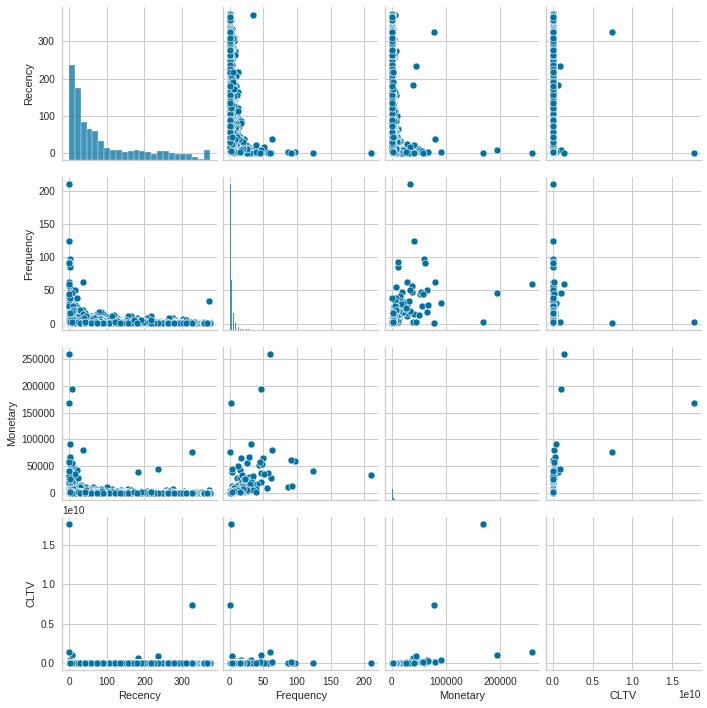

In [18]:
# pairplot
sns.pairplot(RFM_table_cluster)
plt.show()

In [19]:
RFM_table_cluster['Recency'].skew(),RFM_table_cluster['Frequency'].skew(),RFM_table_cluster['Monetary'].skew(),RFM_table_cluster['CLTV'].skew()

(1.24499294569519, 10.80538121517587, 20.217580960310595, 51.781471189641664)

In [20]:
scaler = MinMaxScaler()
RFM_table_cluster_log = np.log(RFM_table_cluster+1)
RFM_Cluster_Tran = pd.DataFrame(scaler.fit_transform(RFM_table_cluster_log),columns=RFM_table_cluster.columns,index=RFM_table_cluster.index) 
round(RFM_Cluster_Tran.describe(),2)

,Recency,Frequency,Monetary,CLTV
count,3920.00,3920.00,3920.00,3920.00
mean,0.64,0.14,0.46,0.46
std,0.23,0.15,0.11,0.09
min,0.00,0.00,0.00,0.00
25%,0.49,0.00,0.38,0.40
50%,0.66,0.09,0.45,0.46
75%,0.84,0.24,0.53,0.51
max,1.00,1.00,1.00,1.00


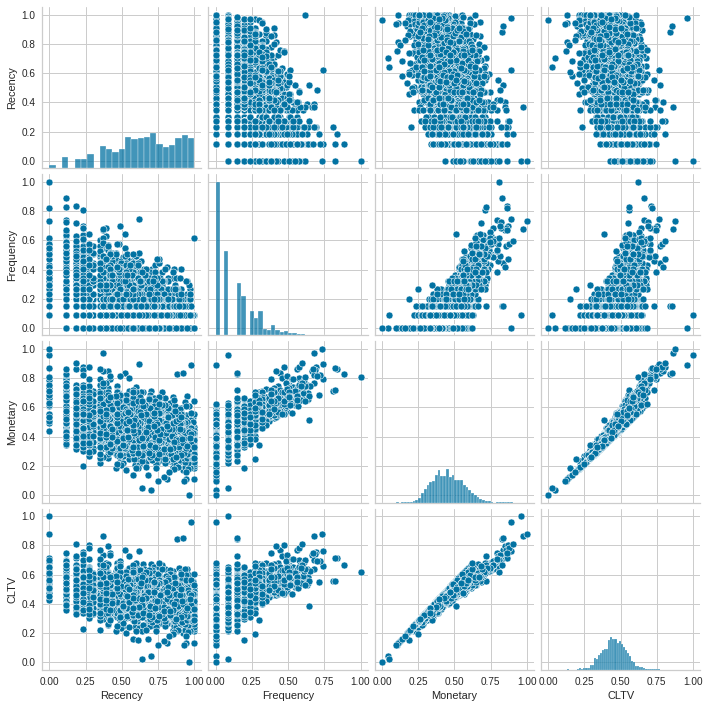

In [21]:
# pairplot
sns.pairplot(RFM_Cluster_Tran)
plt.show()

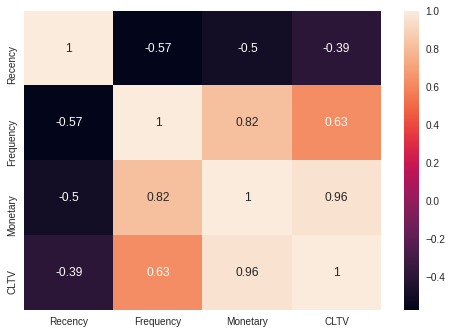

In [22]:
sns.heatmap(RFM_Cluster_Tran.corr(),annot=True)

## **Observations**
- On one hand, we have a negative correlation between:
    - Recency and Frequency
    - Recency and Monetary

- On the other hand, the correlation between Monetary and Frequency is positive and well correlated.

## **Determine the optimal number of clusters** 
#### **Elbow curve**

In [23]:
cl = range(1,11)
wcsse = []
for i in cl:
    mod = KMeans(n_clusters=i,random_state=0) 
    mod.fit(RFM_Cluster_Tran)
    print(mod.inertia_)
    wcsse.append(mod.inertia_)

379.143645160994
190.44338242605167
140.7366120109671
112.59289399682724
94.4081627185038
81.49216971281268
73.50355585798319
67.16960018346948
61.18122194486932
56.964368143547105


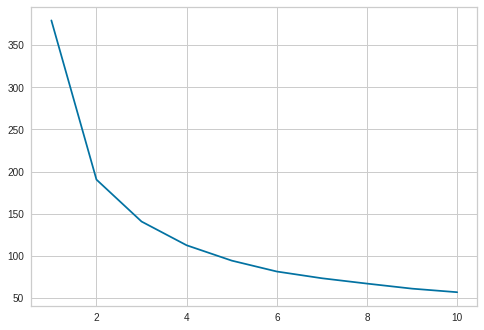

In [24]:
plt.plot(cl,wcsse) # ELBOW Curve

#### **Observations**
- At k = 2/3, there are inflection/elbow points. 
- To confirm it we check for silhoutte score.

#### **Silhouette score**

In [25]:
cl = range(2,11)  
sil1 = []
for i in cl:
    mod = KMeans(n_clusters=i,random_state=0) 
    mod.fit(RFM_Cluster_Tran)
    sil1.append(silhouette_score(RFM_Cluster_Tran,mod.labels_))

In [26]:
sil1

[0.4232362958482472,
 0.33838241979623773,
 0.34634395717358946,
 0.3314606164645819,
 0.32341070082034284,
 0.3122793367742442,
 0.2967399451936105,
 0.2892338607054973,
 0.27991024194236624]

#### **Observations**

- For k=2, the score is high - so k=2 cluster's performance is good.
- Yet, there is no much difference in the scores for cluster 2 and 3. So, lets check for k=3 that way there can be three segments of customers using RFM.

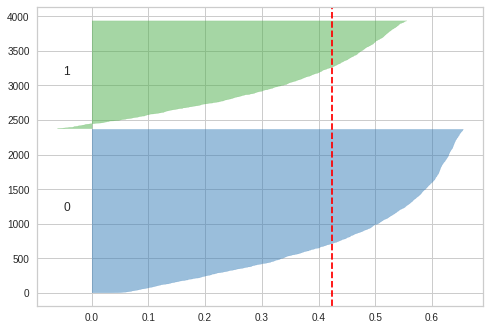

In [27]:
model = KMeans(n_clusters=2, random_state=0)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(RFM_Cluster_Tran)        
plt.show()

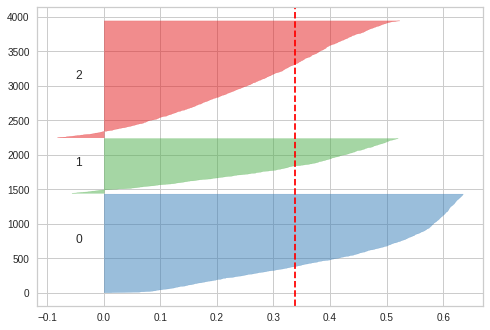

In [28]:
model = KMeans(n_clusters=3, random_state=0)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(RFM_Cluster_Tran)        
plt.show()

#### **Observations**

- From the thickness of the silhouette plot the cluster size can be visualized. The silhouette plot for cluster 0 when n_clusters is equal to 2, is bigger in size owing to the grouping of the 2 sub clusters into one big cluster. However when the n_clusters is equal to 3, all the plots are more or less of similar thickness and hence are of similar sizes as can be also verified from the labelled scatter plot on the right. So, picking 3 clusters.

For cluster = 3, 
- All the cluster crosses the avg silhouette score line - which is a good indicator.
- Should have rectangular band - clusters doesn't have a rectangular shape.
- Clusters have negative silhoute scores - This indicates that few data points might have been assigned to the wrong cluster.

In [29]:
kmeans = KMeans(n_clusters=3,random_state=0)
kmeans = kmeans.fit(RFM_Cluster_Tran)
labels = kmeans.predict(RFM_Cluster_Tran)
centroids = kmeans.cluster_centers_
print("Centroid values")
print(centroids)  

Centroid values
[[0.87168074 0.03939031 0.37737774 0.40354494]
 [0.31705102 0.33368854 0.58620325 0.53694085]
 [0.59899424 0.13448857 0.46291138 0.46251172]]


In [30]:
labels= kmeans.predict(RFM_Cluster_Tran)
RFM_labels = RFM_table_cluster.copy()
RFM_labels['Group'] = labels

In [31]:
RFM_labels.head()

,Recency,Frequency,Monetary,CLTV,Group
0,325,1,77183.60,7.446635e+09,0
1,2,11,4196.01,2.000739e+06,1
2,0,210,33053.19,6.503056e+06,1
3,3,5,4090.88,4.183825e+06,1
4,3,4,942.34,2.775015e+05,1


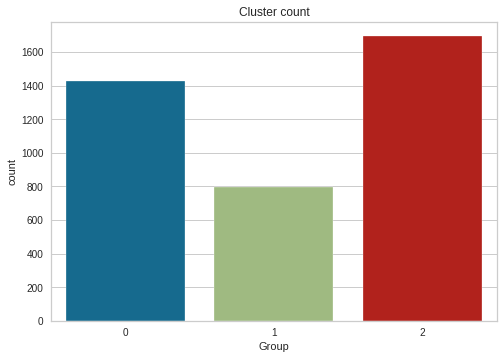

In [32]:
plt.title('Cluster count')
sns.countplot(x=RFM_labels.Group);

In [33]:
RFM_labels.Group.value_counts()

2    1695
0    1430
1     795
Name: Group, dtype: int64

#### **Observations**
- There are 1695 customers in cluster 2 while cluster 0 and cluster 1 has 1430 and 795 customers respectively.

In [34]:
RFM_Cluster_Tran['Group'] = RFM_labels['Group']

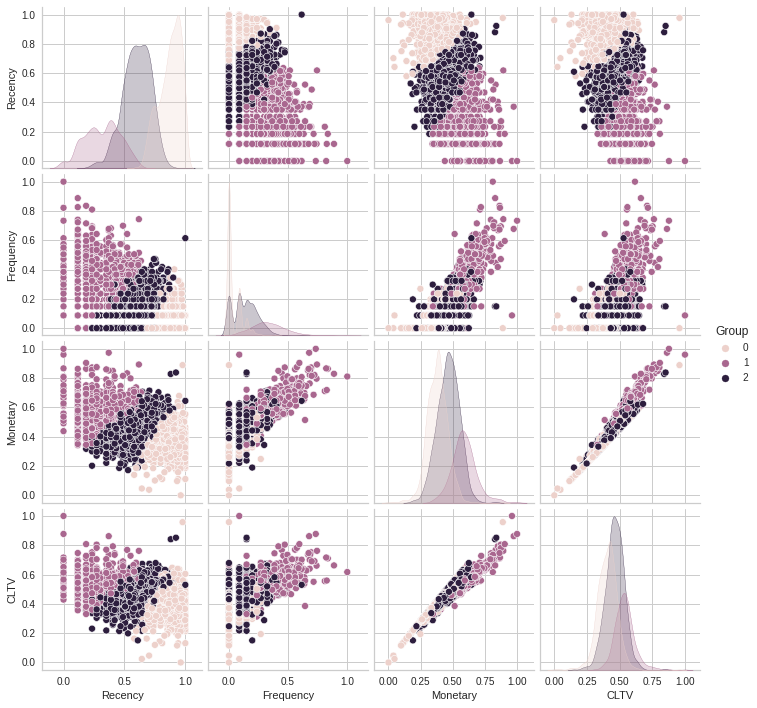

In [35]:
sns.pairplot(RFM_Cluster_Tran,diag_kind='kde',hue='Group')

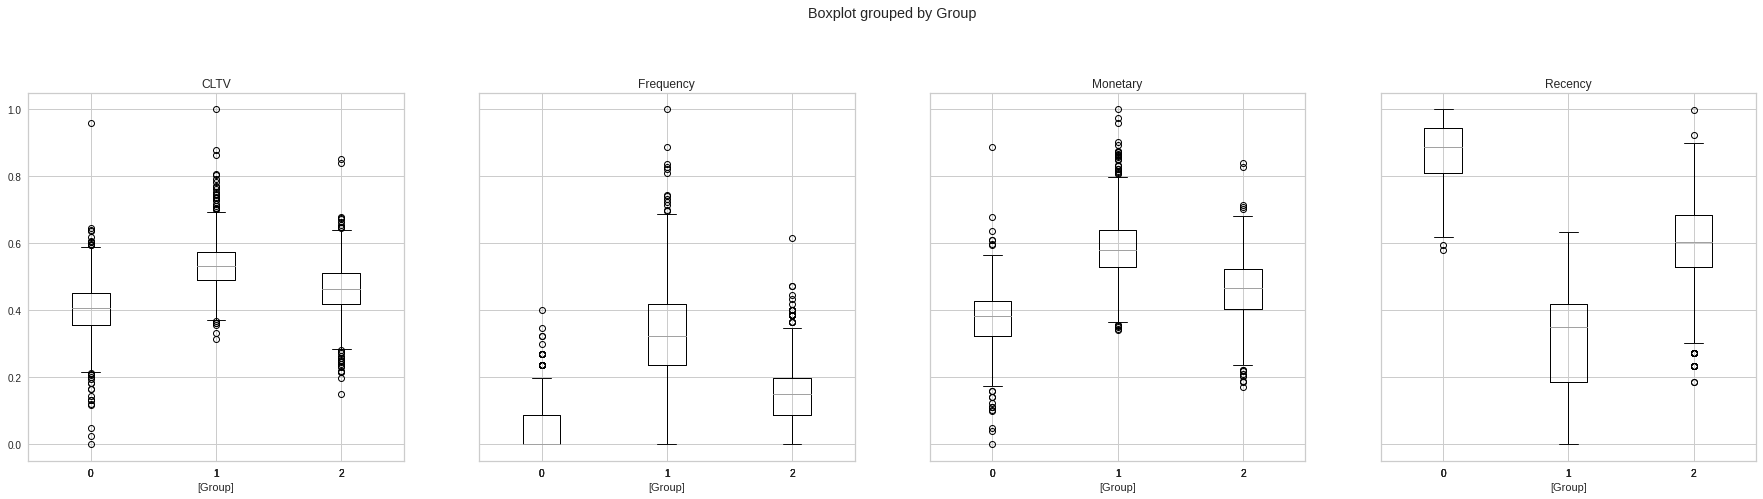

In [36]:
RFM_Cluster_Tran.boxplot(by = 'Group',layout=(2,4), figsize=(30, 15))
plt.show()

In [37]:
RFM_labels.groupby('Group').mean()

,Recency,Frequency,Monetary,CLTV
Group,,,,
0,197.067832,1.528671,467.068973,5.446233e+06
1,8.237736,11.353459,5875.987208,3.076597e+07
2,42.048968,3.207080,1147.909252,1.593585e+06


# **Observations**

- Though there is cluster overlaps, the mean of the features seems to be quite distinguished where cluster 1 has top scores with high mean value. This suggests they are **High value RFM and CLV** segment.
- Cluster 0 and 2 be the **Low value RFM and CLV** and **Mid value RFM and CLV** segments.
- There are less customers(797) who bring in good business and stays loyal to the company. 
- More number of customers (1640) are in Mid-Level, measures have to be taken to convert them to high value customers.

We can start taking actions with this segmentation. The main strategies are quite clear:
- High Value: Champions and Loyal customers
- Mid Value : Promising customers and Customers Needing attention
- Low Value : At risk and lost customers

## Classification of Cluster labels 
- When a new customer comes in, he can be put into any of these clusters for applying further strategies.

In [38]:
RFM_labels

,Recency,Frequency,Monetary,CLTV,Group
0,325,1,77183.60,7.446635e+09,0
1,2,11,4196.01,2.000739e+06,1
2,0,210,33053.19,6.503056e+06,1
3,3,5,4090.88,4.183825e+06,1
4,3,4,942.34,2.775015e+05,1
...,...,...,...,...,...
3915,277,1,180.60,4.077045e+04,0
3916,180,1,80.82,8.164840e+03,0
3917,7,2,178.05,1.981363e+04,2
3918,3,16,2045.53,3.268901e+05,1


In [39]:
from sklearn.model_selection import train_test_split
x = RFM_labels.drop('Group',1)
y = RFM_labels['Group']
X_train, X_test, y_train, y_test = train_test_split(x, y,test_size=0.2,random_state=0)

In [40]:
from sklearn.metrics import classification_report,confusion_matrix,cohen_kappa_score
from xgboost import XGBClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [41]:
dt = DecisionTreeClassifier()
ltv_dt_model = dt.fit(X_train, y_train)

print('Accuracy of DT classifier on training set: {:.2f}'
       .format(ltv_dt_model.score(X_train, y_train)))
print('Accuracy of DT classifier on test set: {:.2f}'
       .format(ltv_dt_model.score(X_test[X_train.columns], y_test)))

Accuracy of DT classifier on training set: 1.00
Accuracy of DT classifier on test set: 0.95


In [42]:
y_pred = ltv_dt_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       287
           1       0.93      0.94      0.94       150
           2       0.95      0.93      0.94       347

    accuracy                           0.95       784
   macro avg       0.95      0.95      0.95       784
weighted avg       0.95      0.95      0.95       784



In [43]:
rf = RandomForestClassifier()
ltv_rf_model = rf.fit(X_train, y_train)

print('Accuracy of RF classifier on training set: {:.2f}'
       .format(ltv_rf_model.score(X_train, y_train)))
print('Accuracy of RF classifier on test set: {:.2f}'
       .format(ltv_rf_model.score(X_test[X_train.columns], y_test)))

Accuracy of RF classifier on training set: 1.00
Accuracy of RF classifier on test set: 0.97


In [44]:
y_pred = ltv_rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       287
           1       0.95      0.95      0.95       150
           2       0.97      0.95      0.96       347

    accuracy                           0.97       784
   macro avg       0.96      0.97      0.97       784
weighted avg       0.97      0.97      0.97       784



In [45]:
xgb = XGBClassifier()
ltv_xgb_model = xgb.fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(ltv_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(ltv_xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 1.00
Accuracy of XGB classifier on test set: 0.97


In [46]:
y_pred = ltv_xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       287
           1       0.96      0.94      0.95       150
           2       0.97      0.96      0.96       347

    accuracy                           0.97       784
   macro avg       0.97      0.96      0.97       784
weighted avg       0.97      0.97      0.97       784



In [47]:
yprob=ltv_xgb_model.predict_proba(X_test)
yprob1=yprob[:,1]
ypred=dt.predict(X_test)
cm=confusion_matrix(y_test,ypred)

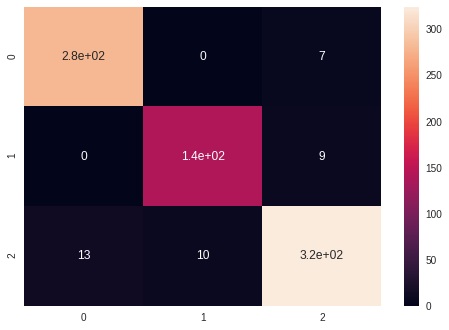

In [48]:
sns.heatmap(cm,annot=True);

In [49]:
cohen_kappa_score(y_test,ypred)

0.9215869311551925

- Considering XGboost model as the final model as the Precision scores are high for every cluster and final accuracy is also high.